In [6]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


F:\7_Practice\DLcourse


This file creates a multi-class classifier for the Glass identification 
dataset using logistic regression and gradient descent.

A multi-class classifer can be decomposed into multiple binary classifer,
so the codes are just wrapped like that.
This task seems quite difficult, because the scatter plot of the data points
are highly tangled...
The overall accuracy is 66.154%

The low accuracy may reslut from inadequate or improper features, which leads to these discussions:
- Class 1~4 involves the jargon "float process", which is a technique to produce flat glass.
  In float process, raw materials of glass are melt down and poured onto liquid stannum (Sn), and a dividing boundary forms between the material and Sn, just like oil and water. We can get a piece of flat glass though it.
  If we know the proportion of Sn in the glass, the model may be more confident to classify the two process techniques.
- Reflective index (RI) belongs to optical features, but we may also want to know the clearness and color of each type of glass, since they are more closely connected with the usage. For example, extre clean glass usually contains little Fe.
- The usage of glass depends on both material and process, it will be better if we can know more about the process of those glass, e.g., tempered, surface enhancement and poly-organic-materials. But that seems to be cheating, since the task is to classify the progress based on element composition.

In [63]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing as pre
from IPython.core.interactiveshell import InteractiveShell
from matplotlib.pyplot import plot
from sklearn.model_selection import train_test_split

InteractiveShell.ast_node_interactivity = 'all'

In [64]:
def binClassifier(XTrain, yTrain, initRate, numEpoch=2000):
    theta = np.zeros((XTrain.shape[1]))
    lossList = []
    learningRate = initRate
    for epoch in range(numEpoch):
        # forward 
        logits = np.dot(XTrain, theta)
        hyp = 1/(1+np.exp(-logits))
        
        # uncomment this line to get an error.....
        # hyp.shape = (hyp.size, 1) 
        
        crossEntropyLoss = (-yTrain * np.log(hyp) - (1-yTrain)*np.log(1-hyp)).mean()

        # backward
        grad = (hyp - yTrain)@XTrain/yTrain.size
        theta -= learningRate*grad

        if epoch % 50 == 0:
            lossList.append(crossEntropyLoss)
            # print('Epoch', epoch, 'loss:', crossEntropyLoss)
            if len(lossList) > 5:
                currentLoss = np.array(lossList[-5:-1])
                if currentLoss.std()/currentLoss.mean() < 0.01:
                    learningRate *= 0.95
                    # print('almost converged, lowering learning rate')
            if learningRate/initRate < 0.5:
                # print('solution already converged, exit training')
                break
                
    return theta


In [65]:

def multiClassifier(XTrain, yTrain, initRate=0.02):
    numClass = np.unique(yTrain)
    print(len(numClass), " classes in total")
    params = np.zeros((len(numClass), XTrain.shape[1]))

    for i in numClass:
        # print('\nbegin to train a binary classifer for class ', i)
        tempLabel = np.zeros_like(yTrain)
        tempLabel[yTrain == numClass[i]] = 1
        params[i,:] = binClassifier(XTrain, tempLabel, initRate)
    
    # print('finish training for all classes!\n')
    return params

In [66]:
def predClass(params, XTest, yTest):
    featSize = XTest.shape
    labelSize = yTest.shape
    assert(featSize[0]==labelSize[0])

    logits = np.dot(XTest, np.transpose(params)).squeeze()
    prob = 1 / (1+np.exp(-logits))

    pred = np.argmax(prob, axis=1)
    accuracy = np.sum(pred == yTest) / labelSize[0] * 100
    
    pred[pred>=3]+=1
    pred+=1
    
    return prob, pred, accuracy

In [67]:
# load data from the file
data = pd.read_csv("data/glass_ident/glass.data",delimiter=',', header=0)
#data.head()
X, y = data.iloc[:,1:-1], pre.LabelEncoder().fit_transform(data.iloc[:, -1])
X, y = np.array(X), np.array(y)
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.3, random_state=21)
featMean, featStd = np.mean(XTrain, axis=0), np.std(XTrain, axis=0)
XTrain = (XTrain - featMean) / featStd
XTest = (XTest - featMean) / featStd

# Concatenate X with a new dimension for bias
XTrain = np.concatenate((np.ones((XTrain.shape[0], 1)), XTrain), axis=1)
XTest = np.concatenate((np.ones((XTest.shape[0], 1)), XTest), axis=1)

In [73]:
initRate = 0.02
params = multiClassifier(XTrain, yTrain, initRate)
prob, preds, accu = predClass(params, XTest, yTest)
print("Prediction: {}\n".format(preds))
print("Accuracy: {:.3f}%".format(accu))

6  classes in total
Prediction: [1 1 1 1 2 7 2 1 2 2 2 2 2 2 7 1 2 2 2 1 2 2 1 1 6 1 2 1 1 7 2 2 2 2 2 1 2
 2 2 1 2 2 1 2 2 2 2 1 1 7 7 1 1 5 1 2 2 7 7 1 1 2 2 2 1]

Accuracy: 66.154%


In [74]:
params.shape

(6, 10)

(10,)

C:\Users\Weijiang\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  from ipykernel import kernelapp as app
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


accuracy for class  0 is :  0.0


Text(0.5, 1.0, 'Train set')

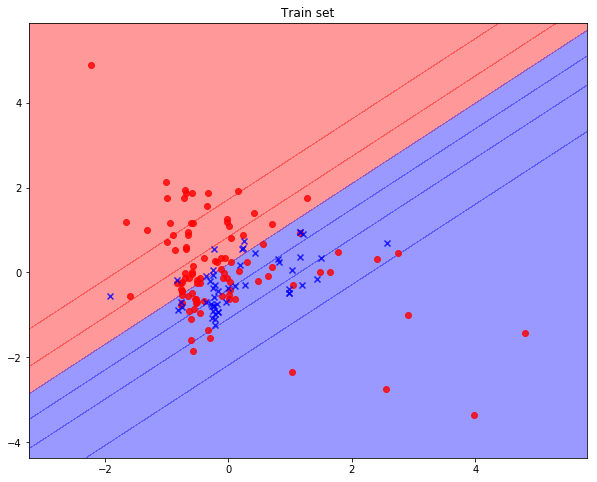

In [78]:

# I've tried several pairs of features..none of them looks good
# if the classifier can successfully distinguish class1 from others, 
# those points shold lie on the same side of a line..
# but reality is tough...
import sys, os
sys.path.append(os.getcwd())
from deeplearning import plot_decision_regions
observedClass = 0
theta = params[observedClass,:]
theta.shape
tempY = np.zeros_like(yTrain)
tempY[yTrain == observedClass] = 1
pred = np.argmax(prob, axis=1)
accuracy = np.sum(pred == tempY) / yTest.shape[0] * 100
print('accuracy for class ',observedClass,'is : ', accuracy)
plot_decision_regions(XTrain[:, 1:], tempY, theta[3:5])
plt.title('Train set')
plt.show()


In [71]:
a = np.array(range(0,5))
b = np.array(range(0,5))

a.shape = (5,1)
b.shape = (1,5)
a-b

a.shape = (5,1)
b.shape = (5,)
a-b

array([[ 0, -1, -2, -3, -4],
       [ 1,  0, -1, -2, -3],
       [ 2,  1,  0, -1, -2],
       [ 3,  2,  1,  0, -1],
       [ 4,  3,  2,  1,  0]])

array([[ 0, -1, -2, -3, -4],
       [ 1,  0, -1, -2, -3],
       [ 2,  1,  0, -1, -2],
       [ 3,  2,  1,  0, -1],
       [ 4,  3,  2,  1,  0]])